### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import warnings


In [2]:
atac_data_df = pd.read_csv('../../data/embryo/raw/atac_peak_matrix_complete_sparse.csv', index_col=0)


In [3]:
rna_data = pl.read_csv("../../data/embryo/raw/scRNA_countMatrix.csv", ignore_errors=True)
rna_data.head()


shape: (5, 68_854)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│          ┆ 10h-1_CEL ┆ 10h-1_CEL ┆ 10h-1_CEL ┆ … ┆ 6h_3 CELL ┆ 6h_3 CELL ┆ 6h_3 CELL ┆ 6h_3 CELL │
│ ---      ┆ L1140_N1_ ┆ L1447_N1_ ┆ L1347_N1_ ┆   ┆ 4434_N1 _ ┆ 5403_N1 _ ┆ 5489_N1 _ ┆ 5447_N1 _ │
│ str      ┆ 10h-1     ┆ 10h-1     ┆ 10h-1     ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64       │
│          ┆ i64       ┆ i64       ┆ i64       ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ rpl13a   ┆ 46        ┆ 22        ┆ 27        ┆ … ┆ 3         ┆ 7         ┆ 1         ┆ 1         │
│ khdrbs1a ┆ 81        ┆ 59        ┆ 36        ┆ … ┆ 34        ┆ 23        ┆ 27        ┆ 51        │
│ apoeb    ┆ 97        ┆ 116       ┆ 193       ┆ … ┆ 19        ┆ 4         ┆ 2         ┆ 1         │
│ cfl1     ┆ 11        ┆ 9         ┆ 10        ┆ … ┆ 8         ┆ 5         ┆ 3         ┆ 6         │
│ polr2d   ┆ 5         ┆ 1         ┆ 1         ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 3         │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [4]:
# Convert to dictionary first, then to pandas
data_dict = rna_data.to_dict(as_series=False)
rna_data_df = pd.DataFrame(data_dict)
# make 1st colun the index 
rna_data_df.set_index(rna_data_df.columns[0], inplace=True)
rna_data_df


10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                                46.0                     22.0   
khdrbs1a                              81.0                     59.0   
apoeb                                 97.0                    116.0   
cfl1                                  11.0                      9.0   
polr2d                                 5.0                      1.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                                27.0                     18.0   
khdrbs1a                              36.0                     60.0   
apoeb                                193.0                     25.0   
cfl1                                  10.0                     21.0   
polr2d                                 1.0                      6.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                              73.0                    74.0   
khdrbs1a                           156.0                   165.0   
apoeb                               26.0                   565.0   
cfl1                                30.0                    37.0   
polr2d                               3.0                     3.0   
...                                  ...                     ...   
CU570797.5                           0.0                     0.0   
trgv5                                0.0                     0.0   
BX950188.3                           0.0                     0.0   
BX548038.2                           0.0                     0.0   
si:ch1073-394i4.1                    0.0                     0.0   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                               90.0                    96.0   
khdrbs1a                            184.0                   193.0   
apoeb                                93.0                    46.0   
cfl1                                 48.0                    65.0   
polr2d                                5.0                     6.0   
...                                   ...                     ...   
CU570797.5                            0.0                     0.0   
trgv5                                 0.0                     0.0   
BX950188.3                            0.0                     0.0   
BX548038.2                            0.0                     0.0   
si:ch1073-394i4.1                     0.0                     0.0   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                               58.0                    53.0  ...   
khdrbs1a                            118.0                   149.0  ...   
apoeb                                94.0                   141.0  ...   
cfl1              

In [5]:
# Load RNA data - remove empty rows and columns and set gene names as index
rna_data_df[rna_data_df.isna().any(axis=1)]

rna_data_df.dropna(axis=0, how='any', inplace=True)

rna_data_df 



10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                                46.0                     22.0   
khdrbs1a                              81.0                     59.0   
apoeb                                 97.0                    116.0   
cfl1                                  11.0                      9.0   
polr2d                                 5.0                      1.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                                27.0                     18.0   
khdrbs1a                              36.0                     60.0   
apoeb                                193.0                     25.0   
cfl1                                  10.0                     21.0   
polr2d                                 1.0                      6.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                              73.0                    74.0   
khdrbs1a                           156.0                   165.0   
apoeb                               26.0                   565.0   
cfl1                                30.0                    37.0   
polr2d                               3.0                     3.0   
...                                  ...                     ...   
CU570797.5                           0.0                     0.0   
trgv5                                0.0                     0.0   
BX950188.3                           0.0                     0.0   
BX548038.2                           0.0                     0.0   
si:ch1073-394i4.1                    0.0                     0.0   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                               90.0                    96.0   
khdrbs1a                            184.0                   193.0   
apoeb                                93.0                    46.0   
cfl1                                 48.0                    65.0   
polr2d                                5.0                     6.0   
...                                   ...                     ...   
CU570797.5                            0.0                     0.0   
trgv5                                 0.0                     0.0   
BX950188.3                            0.0                     0.0   
BX548038.2                            0.0                     0.0   
si:ch1073-394i4.1                     0.0                     0.0   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                               58.0                    53.0  ...   
khdrbs1a                            118.0                   149.0  ...   
apoeb                                94.0                   141.0  ...   
cfl1              

In [6]:
# transform rna data - log2(x+1) for downstream steps
rna_data_log = rna_data_df.copy()
rna_data_log.iloc[:, 0:] = np.log2(rna_data_log.iloc[:, 0:].astype(float) + 1)
rna_data_log

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                            5.554589                 4.523562   
khdrbs1a                          6.357552                 5.906891   
apoeb                             6.614710                 6.870365   
cfl1                              3.584963                 3.321928   
polr2d                            2.584963                 1.000000   
...                                    ...                      ...   
CU570797.5                        0.000000                 0.000000   
trgv5                             0.000000                 0.000000   
BX950188.3                        0.000000                 0.000000   
BX548038.2                        0.000000                 0.000000   
si:ch1073-394i4.1                 0.000000                 0.000000   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                            4.807355                 4.247928   
khdrbs1a                          5.209453                 5.930737   
apoeb                             7.599913                 4.700440   
cfl1                              3.459432                 4.459432   
polr2d                            1.000000                 2.807355   
...                                    ...                      ...   
CU570797.5                        0.000000                 0.000000   
trgv5                             0.000000                 0.000000   
BX950188.3                        0.000000                 0.000000   
BX548038.2                        0.000000                 0.000000   
si:ch1073-394i4.1                 0.000000                 0.000000   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                          6.209453                6.228819   
khdrbs1a                        7.294621                7.375039   
apoeb                           4.754888                9.144658   
cfl1                            4.954196                5.247928   
polr2d                          2.000000                2.000000   
...                                  ...                     ...   
CU570797.5                      0.000000                0.000000   
trgv5                           0.000000                0.000000   
BX950188.3                      0.000000                0.000000   
BX548038.2                      0.000000                0.000000   
si:ch1073-394i4.1               0.000000                0.000000   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                           6.507795                6.599913   
khdrbs1a                         7.531381                7.599913   
apoeb                            6.554589                5.554589   
cfl1                             5.614710                6.044394   
polr2d                           2.584963                2.807355   
...                                   ...                     ...   
CU570797.5                       0.000000                0.000000   
trgv5                            0.000000                0.000000   
BX950188.3                       0.000000                0.000000   
BX548038.2                       0.000000                0.000000   
si:ch1073-394i4.1                0.000000                0.000000   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                           5.882643                5.754888  ...   
khdrbs1a                         6.894818                7.228819  ...   
apoeb                            6.569856                7.149747  ...   
cfl1              

In [7]:
rna_metadata_df = pd.read_csv('../../data/embryo/raw/rna_all.metaData.txt')
rna_metadata_df.rename(columns = {'Unnamed: 0': 'rna_cell'}, inplace=True)
rna_metadata_df

rna_cell orig.ident  nCount_RNA  nFeature_RNA  \
0      10h-1_CELL1140_N1_10h-1      10h-1       16009          3354   
1      10h-1_CELL1447_N1_10h-1      10h-1       11259          2505   
2      10h-1_CELL1347_N1_10h-1      10h-1       12532          2806   
3      10h-1_CELL1204_N1_10h-1      10h-1       14432          3312   
4        10h-1_CELL97_N2_10h-1      10h-1       31455          4443   
...                        ...        ...         ...           ...   
68848       6h_3 CELL5349_N1 _     6hpf_3        2708          1097   
68849       6h_3 CELL4434_N1 _     6hpf_3        3852          1492   
68850       6h_3 CELL5403_N1 _     6hpf_3        2694          1098   
68851       6h_3 CELL5489_N1 _     6hpf_3        2602           972   
68852       6h_3 CELL5447_N1 _     6hpf_3        2626          1097   

       percent.mt  seurat_clusters  stage               celltype  
0        1.467924               14  10hpf   anterior neural keel  
1        1.367795                3  10hpf     neurogenic placode  
2        1.324609               22  10hpf        epithelial Cell  
3        1.489745                8  10hpf               tail bud  
4        1.176284                2  10hpf  posterior neural keel  
...           ...              ...    ...                    ...  
68848    1.289134                1   6hpf               epiblast  
68849    1.011936                1   6hpf               epiblast  
68850    0.667904                1   6hpf               epiblast  
68851    1.345119                1   6hpf               epiblast  
68852    0.837776                1   6hpf               epiblast  

[68853 rows x 8 columns]

In [8]:
atac_metadata_df = pd.read_csv('../../data/embryo/raw/atac_all.metaData.txt', index_col=0)
atac_metadata_df = atac_metadata_df[['celltype', 'predictedCell', 'predictedGroup'] ]
atac_metadata_df.rename(columns = {'celltype': 'atac_cell_type', 'predictedCell': 'rna_matching_cell', 'predictedGroup': 'rna_cell_type'}, inplace=True)
atac_metadata_df.reset_index(names = "atac_cell", inplace=True)
atac_metadata_df.head()


atac_cell atac_cell_type    rna_matching_cell  \
0  3hpf_1#3hpf_1_merge_BC0443_N27     blastomere   6h_3 CELL4645_N1 _   
1  3hpf_1#3hpf_1_merge_BC0069_N07     blastomere  3h1_CELL1337_N1_3h1   
2  3hpf_1#3hpf_1_merge_BC0033_N05     blastomere  3h1_CELL1337_N1_3h1   
3  3hpf_1#3hpf_1_merge_BC0028_N08     blastomere  3h1_CELL1197_N1_3h1   
4  3hpf_1#3hpf_1_merge_BC0264_N08     blastomere  3h1_CELL1197_N1_3h1   

  rna_cell_type  
0        margin  
1    blastomere  
2    blastomere  
3    blastomere  
4    blastomere

In [9]:
celltype_lookup = dict(zip(atac_metadata_df['atac_cell'], atac_metadata_df['atac_cell_type'])) # map the cell types to the atac_cell names
atac_data_df['stage'] = atac_data_df['Cell'].str.extract(r'(\d{1,2})[a-zA-Z]', expand=False)
atac_data_df['celltype'] = atac_data_df['Cell'].map(celltype_lookup)
atac_data_df
atac_data_df['stage_celltype'] = atac_data_df['stage'] + '_' + atac_data_df['celltype']
atac_stage_counts = atac_data_df.groupby('stage')['Cell'].nunique()
atac_celltype_counts = atac_data_df.groupby('celltype')['Cell'].nunique()


In [10]:
print("shape of atac_data_df:", atac_data_df.shape)
atac_data_df.head()


shape of atac_data_df: (244265812, 5)


Cell  Accessibility stage celltype  \
Peak                                                                          
chr1:12474-12974  24hpf_1#24hpf_1_BC00224_N06              1    24      UND   
chr1:14704-15204  24hpf_1#24hpf_1_BC00224_N06              1    24      UND   
chr1:16672-17172  24hpf_1#24hpf_1_BC00224_N06              3    24      UND   
chr1:18404-18904  24hpf_1#24hpf_1_BC00224_N06              3    24      UND   
chr1:19206-19706  24hpf_1#24hpf_1_BC00224_N06              2    24      UND   

                 stage_celltype  
Peak                             
chr1:12474-12974         24_UND  
chr1:14704-15204         24_UND  
chr1:16672-17172         24_UND  
chr1:18404-18904         24_UND  
chr1:19206-19706         24_UND

In [11]:
# create mean dataframe
atac_mean_psd  = atac_data_df.pivot_table(index='Peak', 
    columns='stage_celltype', values='Accessibility', aggfunc='mean')

# Create std dataframe
atac_std_psd = atac_data_df.pivot_table(index='Peak', 
    columns='stage_celltype', values='Accessibility', aggfunc='std')


In [12]:
atac_mean_psd

stage_celltype           10_UND    10_YSL  10_anterior/posterior axis  \
Peak                                                                    
chr10:10002124-10002624     2.0  2.000000                    1.800000   
chr10:10003707-10004207     1.0       NaN                    2.000000   
chr10:10004747-10005247     2.0       NaN                    1.750000   
chr10:10008047-10008547     2.0       NaN                    2.060606   
chr10:10009662-10010162     NaN       NaN                    1.800000   
...                         ...       ...                         ...   
chr9:998557-999057          NaN  1.000000                    2.000000   
chr9:9989556-9990056        2.0  1.958333                    1.500000   
chr9:9992990-9993490        2.0  1.333333                    1.000000   
chr9:9997607-9998107        1.5  2.461538                    1.333333   
chr9:9998460-9998960        NaN  2.000000                    1.000000   

stage_celltype           10_lateral plate mesoderm  10_mesenchyme cell  \
Peak                                                                     
chr10:10002124-10002624                   2.000000                 NaN   
chr10:10003707-10004207                        NaN                 NaN   
chr10:10004747-10005247                   2.333333                 NaN   
chr10:10008047-10008547                   2.250000                 NaN   
chr10:10009662-10010162                        NaN                 NaN   
...                                            ...                 ...   
chr9:998557-999057                        1.000000                 NaN   
chr9:9989556-9990056                      2.000000                 NaN   
chr9:9992990-9993490                      2.000000                 NaN   
chr9:9997607-9998107                      1.000000                 NaN   
chr9:9998460-9998960                      2.000000                 NaN   

stage_celltype           10_neural crest  10_neural keel  \
Peak                                                       
chr10:10002124-10002624         2.000000        2.166667   
chr10:10003707-10004207         2.000000        1.888889   
chr10:10004747-10005247         2.285714        2.153846   
chr10:10008047-10008547         2.200000        2.116279   
chr10:10009662-10010162         1.750000        2.000000   
...                                  ...             ...   
chr9:998557-999057              1.500000        2.000000   
chr9:9989556-9990056            1.500000        2.750000   
chr9:9992990-9993490                 NaN        1.000000   
chr9:9997607-9998107                 NaN        2.333333   
chr9:9998460-9998960            2.000000        1.666667   

stage_celltype           10_periderm/epidermis  10_segmental plate  12_UND  \
Peak                                                                         
chr10:10002124-10002624               4.000000            2.000000     NaN   
chr10:10003707-10004207                    NaN            1.666667     NaN   
chr10:10004747-10005247               1.666667            1.666667     2.0   
chr10:10008047-10008547               2.000000            2.250000     2.0   
chr10:10009662-10010162               1.500000            3.000000     NaN   
...                                        ...                 ...     ...   
chr9:998557-999057                         NaN            2.166667     NaN   
chr9:9989556-9990056                  2.000000            2.000000     NaN   
chr9:9992990-9993490                  1.000000                 NaN     NaN   
chr9:9997607-9998107                  4.000000            1.666667     1.0   
chr9:9998460-9998960                       NaN            2.000000     NaN   

stage_celltype           ...     5_EVL  5_YSL/presumptive endoderm  \
Peak                     ...                                         
chr10:10002124-10002624  ...  1.571429                    3.000000   
chr10:10003707-10004207  ...  1.545455                    3.000000   
chr10:10004

In [13]:

def extract_stage_from_cell_id(cell_id, stage_delimiter='hpf', pos=0):
    stage_parts = str(cell_id).split(stage_delimiter)
    stage = stage_parts[pos]
    stage = stage.replace('h', '')
    return stage

atac_metadata_df['rna_stage'] = atac_metadata_df['rna_matching_cell'].apply(lambda x: extract_stage_from_cell_id(x, 'h', 0))
atac_metadata_df['atac_stage'] = atac_metadata_df['atac_cell'].apply(lambda x: extract_stage_from_cell_id(x, 'hpf', 0))
atac_metadata_df['pseudobulk'] = atac_metadata_df['atac_stage'].astype(str) + '_' + atac_metadata_df['atac_cell_type']
atac_metadata_df.head( )

atac_cell atac_cell_type    rna_matching_cell  \
0  3hpf_1#3hpf_1_merge_BC0443_N27     blastomere   6h_3 CELL4645_N1 _   
1  3hpf_1#3hpf_1_merge_BC0069_N07     blastomere  3h1_CELL1337_N1_3h1   
2  3hpf_1#3hpf_1_merge_BC0033_N05     blastomere  3h1_CELL1337_N1_3h1   
3  3hpf_1#3hpf_1_merge_BC0028_N08     blastomere  3h1_CELL1197_N1_3h1   
4  3hpf_1#3hpf_1_merge_BC0264_N08     blastomere  3h1_CELL1197_N1_3h1   

  rna_cell_type rna_stage atac_stage    pseudobulk  
0        margin         6          3  3_blastomere  
1    blastomere         3          3  3_blastomere  
2    blastomere         3          3  3_blastomere  
3    blastomere         3          3  3_blastomere  
4    blastomere         3          3  3_blastomere

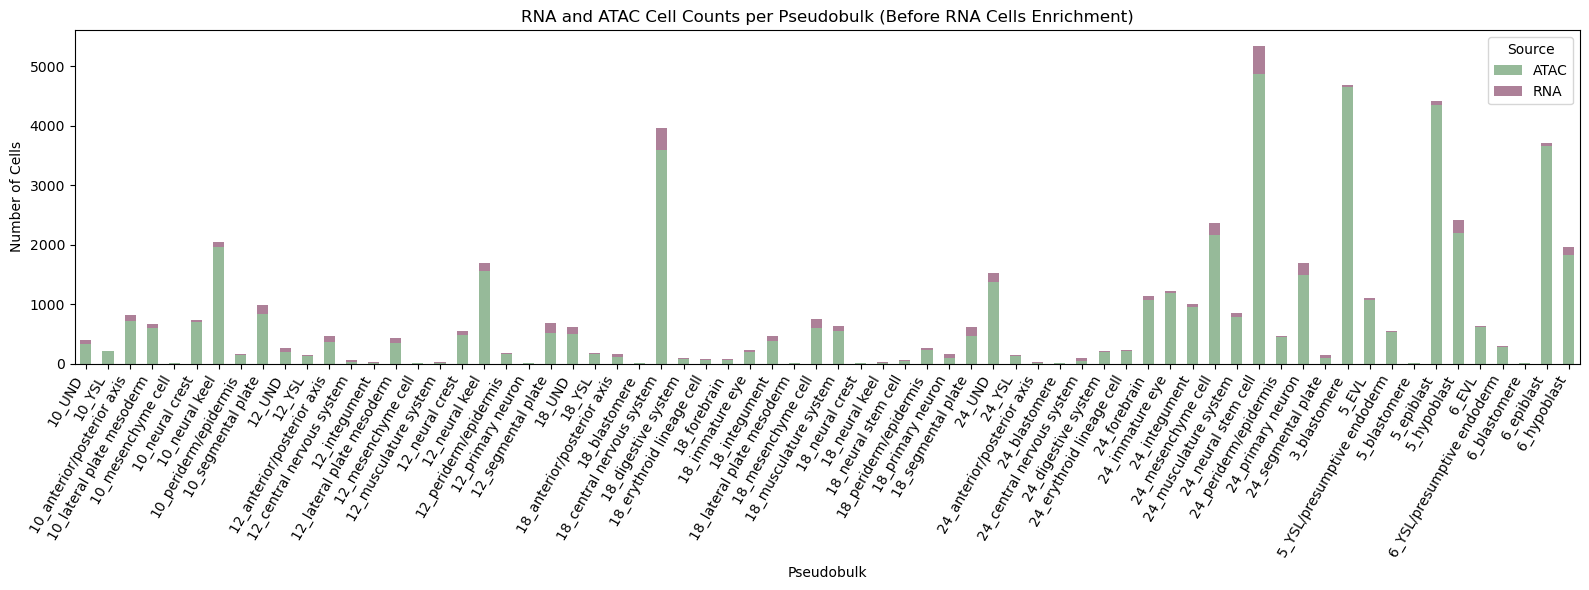

In [14]:
atac_counts = atac_metadata_df.groupby('pseudobulk')['atac_cell'].nunique().reset_index(name='ATAC')
rna_counts = atac_metadata_df.groupby('pseudobulk')['rna_matching_cell'].nunique().reset_index(name='RNA')

stacked_counts = pd.merge(atac_counts, rna_counts, on='pseudobulk', how='outer').fillna(0)
stacked_counts[['ATAC', 'RNA']] = stacked_counts[['ATAC', 'RNA']].astype(int)

stacked_counts.set_index('pseudobulk')[['ATAC', 'RNA']].plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    color=['#96ba99', '#ad8098']
)

plt.xticks(rotation=60, ha='right')
plt.xlabel('Pseudobulk')
plt.ylabel('Number of Cells')
plt.title('RNA and ATAC Cell Counts per Pseudobulk (Before RNA Cells Enrichment)')
plt.legend(title='Source')
plt.tight_layout()
plt.show()



#### Only 2258 RNA cells are assigned to ATAC cells

In [15]:
# filter rna_data_log to only keep the rows with max  value >=4
rna_data_log_filter_low_genes = rna_data_log[rna_data_log.max(axis=1) >= 4]
rna_data_log_filter_low_genes

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   
...                         ...                     ...   
tmc2a                  0.000000                0.000000   
gnb3a                  0.000000                0.000000   
cd164l2                0.000000                0.000000   
cpa5                   0.000000                0.000000   
dharma                 0.000000                0.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   
...                          ...                     ...  ...   
tmc2a                   0.000000                0.000000  ...   
gnb3a                   0.000000                0.000000  ...   
cd164l2                 0.000000                0.000000  ...   
cpa5                    0.000000                0.000000  ...   
dharma                  0.000000                0.000000  ...   

 

In [16]:

# continue with log values
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_data_matched_all_genes = rna_data_log.loc[:, rna_data_log.columns.intersection(matching_cells)]
rna_data_unmatched_all_genes =rna_data_log.loc[:, ~rna_data_log.columns.isin(matching_cells)]




In [17]:
# continue with log values
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_data_matched_filter_low_genes = rna_data_log_filter_low_genes.loc[:, rna_data_log_filter_low_genes.columns.intersection(matching_cells)]
rna_data_unmatched_filter_low_genes = rna_data_log_filter_low_genes.loc[:, ~rna_data_log_filter_low_genes.columns.isin(matching_cells)]
rna_data_unmatched_filter_low_genes

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   
...                         ...                     ...   
tmc2a                  0.000000                0.000000   
gnb3a                  0.000000                0.000000   
cd164l2                0.000000                0.000000   
cpa5                   0.000000                0.000000   
dharma                 0.000000                0.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   
...                          ...                     ...  ...   
tmc2a                   0.000000                0.000000  ...   
gnb3a                   0.000000                0.000000  ...   
cd164l2                 0.000000                0.000000  ...   
cpa5                    0.000000                0.000000  ...   
dharma                  0.000000                0.000000  ...   

 

In [18]:
rna_data_matched_filter_low_genes

10h-1_CELL122_N2_10h-1  10h-1_CELL338_N1_10h-1  \
                                                           
rpl13a                  7.000000                5.930737   
khdrbs1a                7.864186                7.417853   
apoeb                   6.442943                8.179909   
cfl1                    5.977280                5.169925   
polr2d                  3.000000                2.000000   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL789_N1_10h-1  10h-1_CELL32_N2_10h-1  \
                                                          
rpl13a                  5.285402               5.700440   
khdrbs1a                6.845490               6.584963   
apoeb                   5.426265               6.459432   
cfl1                    4.247928               4.643856   
polr2d                  2.584963               2.321928   
...                          ...                    ...   
tmc2a                   0.000000               0.000000   
gnb3a                   0.000000               0.000000   
cd164l2                 0.000000               0.000000   
cpa5                    0.000000               0.000000   
dharma                  0.000000               0.000000   

          10h-1_CELL240_N1_10h-1  10h-1_CELL198_N1_10h-1  \
                                                           
rpl13a                  6.643856                7.066089   
khdrbs1a                7.707359                8.113742   
apoeb                   5.321928                8.174926   
cfl1                    6.149747                5.930737   
polr2d                  2.000000                4.087463   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL183_N1_10h-1  10h-1_CELL794_N1_10h-1  \
                                                           
rpl13a                  6.475733                5.491853   
khdrbs1a                6.149747                7.179909   
apoeb                   5.700440                6.357552   
cfl1                    4.857981                4.169925   
polr2d                  2.321928                2.321928   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL275_N1_10h-1  10h-1_CELL1288_N1_10h-1  ...  \
                                                           ...   
rpl13a                  6.614710                 4.754888  ...   
khdrbs1a                6.569856                 6.491853  ...   
apoeb                   4.523562                 4.700440  ...   
cfl1                    4.754888                 3.906891  ...   
polr2d                  1.584963                 2.321928  ...   
...                          ...                      ...  ...   
tmc2a                   0.000000                 0.000000  ...   
gnb3a                   0.000000                 0.000000  ...   
cd164l2                 0.000000                 0.000000  ...   
cpa5                    0.000000                 0.000000  ...   
dharma                  0.000000                 0.000000  ...   

          6h_3 CELL2532_N1 _  6h_3 CELL4

##### Define a cutoff for each pseudobulk as the distance between this (mean vector of same psd cells) and the most distant cell of the same celltype (from any time point).
##### Compute the distance from same cell type cells to each pseudobulk considering only genes with max log expression >=4
    - To enrich the pseudobulks with unmatched RNA cells we will use this cutoff
    - If a new cell has a distance > cutoff, it is more different than any cell of that type used to define the pseudobulk 

In [19]:
from scipy.spatial.distance import cdist

def compute_pseudobulk_cutoffs_df(rna_data_matched, atac_metadata):
    metadata = atac_metadata.set_index('rna_matching_cell').loc[rna_data_matched.columns].reset_index(names='rna_matching_cell')
    pseudobulk_means = {
        pb: rna_data_matched[metadata[metadata['pseudobulk'] == pb]['rna_matching_cell']].mean(axis=1)
        for pb in metadata['pseudobulk'].unique()
    }

    results = []
    for pb, mean_vec in pseudobulk_means.items():
        celltype = metadata[metadata['pseudobulk'] == pb]['atac_cell_type'].iloc[0]
        same_type_cells = metadata[metadata['atac_cell_type'] == celltype]['rna_matching_cell']
        same_type_matrix = rna_data_matched[same_type_cells].T.values  # shape: (n_cells, n_genes)
        
        mean_vec_reshaped = mean_vec.values.reshape(1, -1)  # shape: (1, n_genes)
        distances = cdist(same_type_matrix, mean_vec_reshaped, metric='euclidean').flatten()  # shape: (n_cells,)
        
        results.append({
            'pseudobulk': pb,
            'atac_cell_type': celltype,
            'cutoff': distances.max(),
            'n_cells_in_pseudobulk': (metadata['pseudobulk'] == pb).sum(),
            'n_cells_same_type': (metadata['atac_cell_type'] == celltype).sum()
        })
    
    return pd.DataFrame(results)

cutoffs_high_exp_genes = compute_pseudobulk_cutoffs_df(rna_data_matched_filter_low_genes, atac_metadata_df)
cutoffs_high_exp_genes


pseudobulk          atac_cell_type      cutoff  \
0              12_neural keel             neural keel  138.797406   
1   18_central nervous system  central nervous system  173.781686   
2             10_neural crest            neural crest  118.594639   
3             12_neural crest            neural crest  117.974890   
4               12_integument              integument  125.629656   
..                        ...                     ...         ...   
63               6_blastomere              blastomere  166.153537   
64          12_primary neuron          primary neuron  167.140716   
65               5_blastomere              blastomere  159.682524   
66                      5_EVL                     EVL  106.988053   
67                      6_EVL                     EVL  112.322791   

    n_cells_in_pseudobulk  n_cells_same_type  
0                    1557               3525  
1                    3599               3672  
2                     694               1177  
3                     478               1177  
4                      10               1336  
..                    ...                ...  
63                      5               4676  
64                      1               1598  
65                      2               4676  
66                   1071               1678  
67                    607               1678  

[68 rows x 5 columns]

In [20]:
# create rna_data_pseudobulk mean and std dataframes for the log transformed data. 
# Aggregate the RNA data by pseudobulk using the matched cells "og"
cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
rna_data_psd_names = rna_data_matched_all_genes.rename(columns=cell_to_pseudobulk)
rna_data_std_pseudobulk_og_all_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
rna_data_mean_pseudobulk_og_all_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()


/tmp/ipykernel_3728772/2255374944.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_pseudobulk_og_all_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
/tmp/ipykernel_3728772/2255374944.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_pseudobulk_og_all_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()


In [21]:
# create rna_data_pseudobulk mean and std dataframes for the log transformed data ONLY for HIGHLY EXPRESSED GENES.
# Aggregate the RNA data by pseudobulk using the matched cells "og"
cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
rna_data_psd_names = rna_data_matched_filter_low_genes.rename(columns=cell_to_pseudobulk)
rna_data_std_pseudobulk_og_filtered_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
rna_data_mean_pseudobulk_og_filtered_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()

rna_data_mean_pseudobulk_og_filtered_genes


/tmp/ipykernel_3728772/1072440255.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_pseudobulk_og_filtered_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
/tmp/ipykernel_3728772/1072440255.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_pseudobulk_og_filtered_genes= rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()


10_UND    10_YSL  10_anterior/posterior axis  \
                                                           
rpl13a    5.084864  2.292481                    5.977550   
khdrbs1a  4.742312  3.284928                    6.498762   
apoeb     2.446045  6.575984                    4.891290   
cfl1      3.911818  2.292481                    4.642868   
polr2d    1.181378  0.000000                    1.874917   
...            ...       ...                         ...   
tmc2a     0.000000  0.000000                    0.000000   
gnb3a     0.000000  0.000000                    0.000000   
cd164l2   0.000000  0.000000                    0.000000   
cpa5      0.000000  0.000000                    0.000000   
dharma    0.000000  0.000000                    0.000000   

          10_lateral plate mesoderm  10_neural crest  10_neural keel  \
                                                                       
rpl13a                     5.505295         5.860131        5.471751   
khdrbs1a                   6.354888         6.985411        6.233713   
apoeb                      4.907480         6.666729        4.654771   
cfl1                       4.655234         4.435093        4.392690   
polr2d                     1.880436         1.776963        1.805762   
...                             ...              ...             ...   
tmc2a                      0.000000         0.000000        0.000000   
gnb3a                      0.000000         0.000000        0.000000   
cd164l2                    0.000000         0.000000        0.000000   
cpa5                       0.000000         0.000000        0.000000   
dharma                     0.000000         0.000000        0.000000   

          10_periderm/epidermis  10_segmental plate    12_UND    12_YSL  ...  \
                                                                         ...   
rpl13a                 4.346743            5.809875  5.433258  1.584963  ...   
khdrbs1a               2.729716            6.072204  5.686432  3.700440  ...   
apoeb                  0.000000            4.813227  3.869535  0.000000  ...   
cfl1                   0.000000            4.284868  4.602898  3.000000  ...   
polr2d                 0.000000            1.900582  1.602456  0.000000  ...   
...                         ...                 ...       ...       ...  ...   
tmc2a                  0.000000            0.000000  0.000000  0.000000  ...   
gnb3a                  0.000000            0.000000  0.000000  0.000000  ...   
cd164l2                0.000000            0.000000  0.000000  0.000000  ...   
cpa5                   0.000000            0.000000  0.000000  0.000000  ...   
dharma                 0.000000            0.000000  0.000000  0.000000  ...   

          3_blastomere     5_EVL  5_YSL/presumptive endoderm  5_epiblast  \
                                                                           
rpl13a        2.850926  4.662160                    1.935785    2.623231   
khdrbs1a      5.354773  7.578096                    3.043094    6.082239   
apoeb         2.321131  2.223308                    5.098626    4.674749   
cfl1          4.364861  5.546121                    2.194988    3.169378   
polr2d        1.321714  1.166667                    0.000000    0.628456   
...                ...       ...                         ...         ...   
tmc2a         0.000000  0.000000                    0.000000    0.000000   
gnb3a         0.000000  0.000000                    0.000000    0.000000   
cd164l2       0.000000  0.000000                    0.000000    0.000000   
cpa5          0.000000  0.000000                    0.000000    0.000000   
dharma        0.058824  0.000000                    0.000000    0.000000   

          5_hypoblast     6_EVL  6_YSL/presumptive endoderm  6_blastomere  \
                                                                            
rpl13a       3.276358  4.178352                    1.905843      2.953445   
khdrbs1a     6.388591  6.952145  

#### assign pseudobulk labels on unmatched cells 
        - considering all genes
        - considering only the genees with argmax log2(x+1) >4

In [22]:
def assign_cells_to_pseudobulks(rna_data_unmatched, rna_data_mean_pseudobulk):
    unmatched_matrix = rna_data_unmatched.T.values 
    pseudobulk_matrix = rna_data_mean_pseudobulk.T.values 
    distance_matrix = cdist(unmatched_matrix, pseudobulk_matrix, metric='euclidean')
    pseudobulk_names = list(rna_data_mean_pseudobulk.columns)
    cell_names = list(rna_data_unmatched.columns)
    closest_indices = np.argmin(distance_matrix, axis=1)
    closest_pseudobulks = [pseudobulk_names[i] for i in closest_indices]
    closest_distances = distance_matrix[np.arange(len(cell_names)), closest_indices]
    cell_to_pseudobulk = dict(zip(cell_names, closest_pseudobulks))
    cell_to_distance = dict(zip(cell_names, closest_distances))

    return cell_to_pseudobulk, cell_to_distance

cell_to_pseudobulk_filtered_genes, cell_to_distance_filtered_genes = assign_cells_to_pseudobulks(rna_data_unmatched_filter_low_genes,rna_data_mean_pseudobulk_og_filtered_genes)
cell_to_pseudobulk_all_genes,cell_to_distance_all_genes= assign_cells_to_pseudobulks(rna_data_unmatched_all_genes, rna_data_mean_pseudobulk_og_all_genes)
print(cell_to_distance_filtered_genes)
print(cell_to_distance_all_genes)

{'10h-1_CELL1140_N1_10h-1': np.float64(58.381652158343904), '10h-1_CELL1447_N1_10h-1': np.float64(62.79282268052861), '10h-1_CELL1347_N1_10h-1': np.float64(64.78497463755943), '10h-1_CELL1204_N1_10h-1': np.float64(57.973648611890596), '10h-1_CELL97_N2_10h-1': np.float64(66.00815487241027), '10h-1_CELL539_N1_10h-1': np.float64(67.47126415339731), '10h-1_CELL310_N1_10h-1': np.float64(75.65321608044691), '10h-1_CELL311_N1_10h-1': np.float64(74.43194665182385), '10h-1_CELL665_N1_10h-1': np.float64(64.24111983506658), '10h-1_CELL350_N1_10h-1': np.float64(76.27175785031268), '10h-1_CELL434_N1_10h-1': np.float64(72.55626714454765), '10h-1_CELL335_N1_10h-1': np.float64(73.63496435818158), '10h-1_CELL1086_N1_10h-1': np.float64(58.45693733106975), '10h-1_CELL2213_N1_10h-1': np.float64(50.275456128088514), '10h-1_CELL646_N1_10h-1': np.float64(61.120589735685016), '10h-1_CELL320_N1_10h-1': np.float64(81.10353244694357), '10h-1_CELL149_N2_10h-1': np.float64(82.90782544470662), '10h-1_CELL1088_N1_10

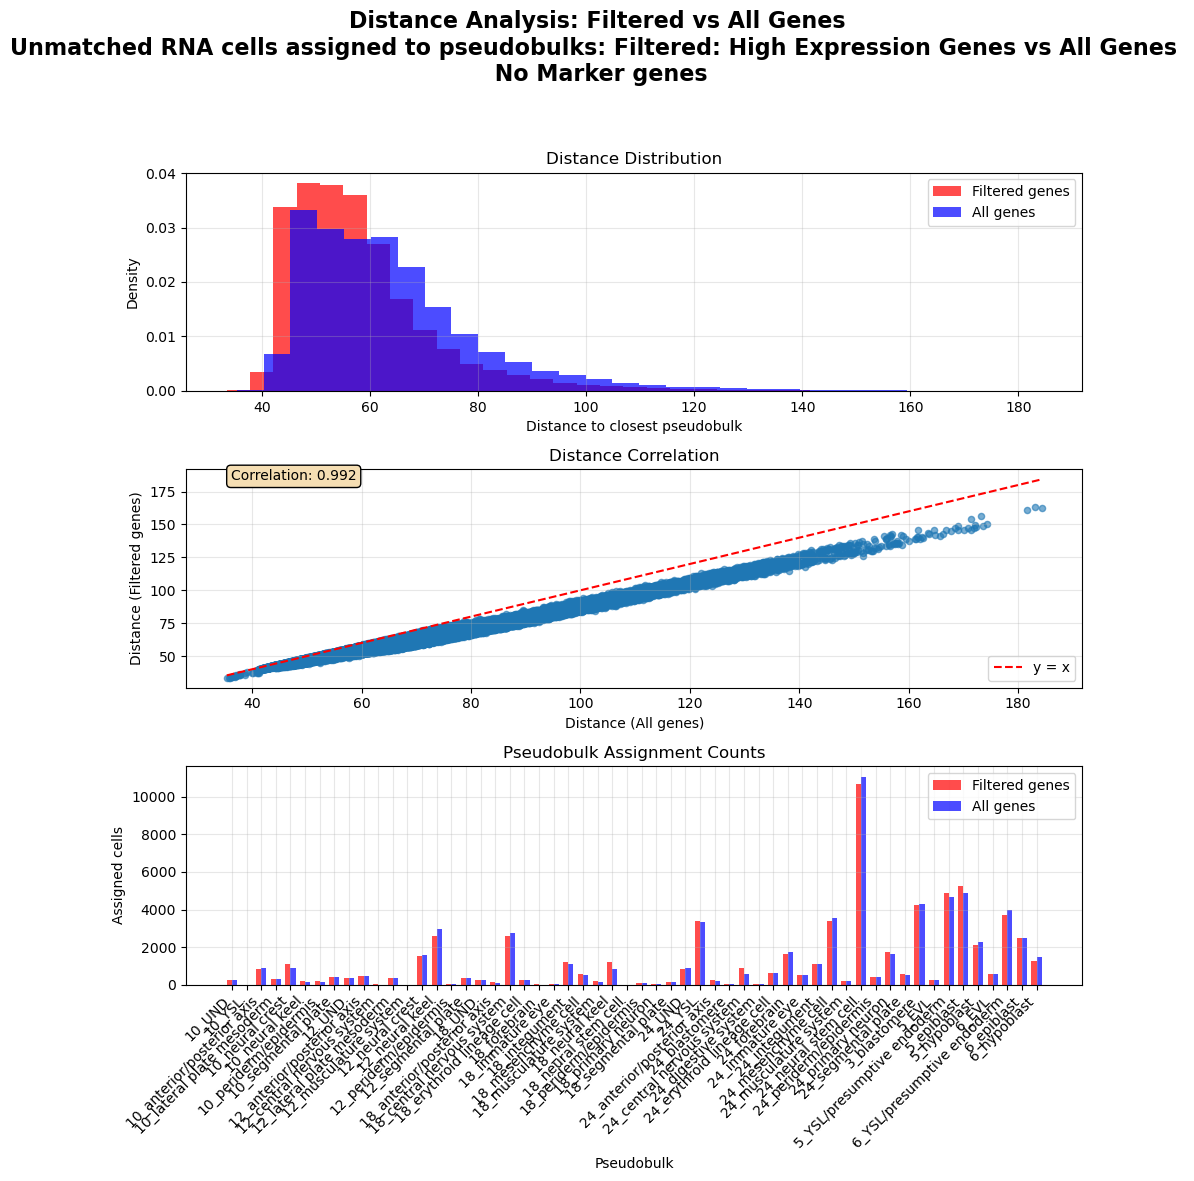

In [23]:
from collections import Counter

def analyze_distance_changes(cell_to_distance_filtered, cell_to_distance_all, 
                                     cell_to_pseudobulk_filtered, cell_to_pseudobulk_all,
                                     title=""):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle(f'Distance Analysis: Filtered vs All Genes\n{title}', fontsize=16, fontweight='bold')

    common_cells = set(cell_to_distance_filtered) & set(cell_to_distance_all)
    distances_filtered = [cell_to_distance_filtered[cell] for cell in common_cells]
    distances_all = [cell_to_distance_all[cell] for cell in common_cells]

    axes[0].hist(distances_filtered, bins=30, alpha=0.7, label='Filtered genes', color='red', density=True)
    axes[0].hist(distances_all, bins=30, alpha=0.7, label='All genes', color='blue', density=True)
    axes[0].set_xlabel('Distance to closest pseudobulk')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distance Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(distances_all, distances_filtered, alpha=0.6, s=20)
    axes[1].plot([min(distances_all), max(distances_all)],
                 [min(distances_all), max(distances_all)], 'r--', label='y = x')
    axes[1].set_xlabel('Distance (All genes)')
    axes[1].set_ylabel('Distance (Filtered genes)')
    axes[1].set_title('Distance Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    correlation = np.corrcoef(distances_all, distances_filtered)[0, 1]
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                 transform=axes[1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

    pseudobulk_counts_filtered = Counter(cell_to_pseudobulk_filtered.values())
    pseudobulk_counts_all = Counter(cell_to_pseudobulk_all.values())
    all_pseudobulks = sorted(set(pseudobulk_counts_filtered) | set(pseudobulk_counts_all))

    counts_filtered = [pseudobulk_counts_filtered.get(pb, 0) for pb in all_pseudobulks]
    counts_all = [pseudobulk_counts_all.get(pb, 0) for pb in all_pseudobulks]

    x_pos = np.arange(len(all_pseudobulks))
    width = 0.35

    axes[2].bar(x_pos - width / 2, counts_filtered, width, label='Filtered genes', color='red', alpha=0.7)
    axes[2].bar(x_pos + width / 2, counts_all, width, label='All genes', color='blue', alpha=0.7)
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(all_pseudobulks, rotation=45, ha='right')
    axes[2].set_xlabel('Pseudobulk')
    axes[2].set_ylabel('Assigned cells')
    axes[2].set_title('Pseudobulk Assignment Counts')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return {
        'distances_filtered': distances_filtered,
        'distances_all': distances_all,
        'correlation': correlation
    }
results = analyze_distance_changes(
    cell_to_distance_filtered_genes,
    cell_to_distance_all_genes,
    cell_to_pseudobulk_filtered_genes,
    cell_to_pseudobulk_all_genes,
    title="Unmatched RNA cells assigned to pseudobulks: Filtered: High Expression Genes vs All Genes \n No Marker genes"
)


#### Some pseudobulks have 0 marker genes - they also have few cells assigned from the original assignment

In [25]:
cell_to_celltype = atac_metadata_df.set_index('rna_matching_cell')['atac_cell_type'].to_dict()

rna_data_celltype_named = rna_data_matched_all_genes.rename(columns=cell_to_celltype)

rna_data_mean_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).mean()
rna_data_std_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).std()
rna_data_mean_celltype


/tmp/ipykernel_3728772/3388908455.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).mean()
/tmp/ipykernel_3728772/3388908455.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).std()


EVL       UND       YSL  YSL/presumptive endoderm  \
                                                                            
rpl13a             4.285865  5.373029  2.145203                  1.914009   
khdrbs1a           7.091245  4.641468  3.531996                  3.754512   
apoeb              1.576994  2.243638  2.475344                  5.692448   
cfl1               4.956887  4.316922  3.133526                  2.318557   
polr2d             0.792308  1.218737  0.325906                  0.181818   
...                     ...       ...       ...                       ...   
CU570797.5         0.000000  0.000000  0.000000                  0.000000   
trgv5              0.000000  0.000000  0.000000                  0.000000   
BX950188.3         0.000000  0.000000  0.000000                  0.000000   
BX548038.2         0.000000  0.000000  0.000000                  0.000000   
si:ch1073-394i4.1  0.000000  0.000000  0.000000                  0.000000   

                   anterior/posterior axis  blastomere  \
                                                         
rpl13a                            5.823040    2.956376   
khdrbs1a                          6.192894    5.289375   
apoeb                             4.387039    2.445933   
cfl1                              4.630494    4.180602   
polr2d                            1.794301    1.273457   
...                                    ...         ...   
CU570797.5                        0.000000    0.000000   
trgv5                             0.000000    0.000000   
BX950188.3                        0.000000    0.000000   
BX548038.2                        0.000000    0.000000   
si:ch1073-394i4.1                 0.000000    0.000000   

                   central nervous system  digestive system  epiblast  \
                                                                        
rpl13a                           5.530406          5.511907  3.900449   
khdrbs1a                         5.399760          4.998037  6.401890   
apoeb                            2.898172          2.825049  5.414615   
cfl1                             4.154317          4.261396  3.827576   
polr2d                           1.676043          0.966178  1.421633   
...                                   ...               ...       ...   
CU570797.5                       0.000000          0.000000  0.000000   
trgv5                            0.000000          0.000000  0.000000   
BX950188.3                       0.000000          0.000000  0.000000   
BX548038.2                       0.000000          0.000000  0.000000   
si:ch1073-394i4.1                0.000000          0.000000  0.000000   

                   erythroid lineage cell  ...  integument  \
                                           ...               
rpl13a                           5.977981  ...    5.279508   
khdrbs1a                         3.778627  ...    3.804133   
apoeb                            0.935194  ...    5.308447   
cfl1                             3.566287  ...    2.456101   
polr2d                           0.714283  ...    0.982613   
...                                   ...  ...         ...   
CU570797.5                       0.000000  ...    0.000000   
trgv5                            0.000000  ...    0.000000   
BX950188.3                       0.000000  ...    0.000000   
BX548038.2                       0.000000  ...    0.000000   
si:ch1073-394i4.1                0.000000  ...    0.000000   

                   lateral plate mesoderm  mesenchyme cell  \
                                                             
rpl13a                           5.424183         5.103153   
khdrbs1a                         6.003210         4.503269   
apoeb                            4.211091         1.651637   
cfl1                             4.508843         4.087893   
polr2d                           1.726063         1.146742   
...                                   ...              ...   
CU570797.5    

In [26]:
rna_data_std_celltype

EVL       UND       YSL  YSL/presumptive endoderm  \
                                                                            
rpl13a             1.121914  1.293915  1.081346                  1.118888   
khdrbs1a           1.123004  1.526927  1.510844                  1.482906   
apoeb              1.147146  2.067198  2.670112                  1.425495   
cfl1               1.074733  1.464695  1.350151                  1.304507   
polr2d             0.745346  1.055721  0.578251                  0.404520   
...                     ...       ...       ...                       ...   
CU570797.5         0.000000  0.000000  0.000000                  0.000000   
trgv5              0.000000  0.000000  0.000000                  0.000000   
BX950188.3         0.000000  0.000000  0.000000                  0.000000   
BX548038.2         0.000000  0.000000  0.000000                  0.000000   
si:ch1073-394i4.1  0.000000  0.000000  0.000000                  0.000000   

                   anterior/posterior axis  blastomere  \
                                                         
rpl13a                            0.769265    1.214380   
khdrbs1a                          0.866239    1.110324   
apoeb                             1.886848    1.826729   
cfl1                              0.787827    1.202377   
polr2d                            0.907220    0.974871   
...                                    ...         ...   
CU570797.5                        0.000000    0.000000   
trgv5                             0.000000    0.000000   
BX950188.3                        0.000000    0.000000   
BX548038.2                        0.000000    0.000000   
si:ch1073-394i4.1                 0.000000    0.000000   

                   central nervous system  digestive system  epiblast  \
                                                                        
rpl13a                           1.260955          0.849709  1.446233   
khdrbs1a                         1.574185          0.890441  0.931561   
apoeb                            2.148247          1.531234  1.685566   
cfl1                             1.200538          0.695464  1.094478   
polr2d                           1.234676          0.888493  1.002820   
...                                   ...               ...       ...   
CU570797.5                       0.000000          0.000000  0.000000   
trgv5                            0.000000          0.000000  0.000000   
BX950188.3                       0.000000          0.000000  0.000000   
BX548038.2                       0.000000          0.000000  0.000000   
si:ch1073-394i4.1                0.000000          0.000000  0.000000   

                   erythroid lineage cell  ...  integument  \
                                           ...               
rpl13a                           0.977063  ...    0.975353   
khdrbs1a                         1.311498  ...    1.498831   
apoeb                            1.567329  ...    2.110379   
cfl1                             1.279312  ...    1.657054   
polr2d                           0.930886  ...    0.953624   
...                                   ...  ...         ...   
CU570797.5                       0.000000  ...    0.000000   
trgv5                            0.000000  ...    0.000000   
BX950188.3                       0.000000  ...    0.000000   
BX548038.2                       0.000000  ...    0.000000   
si:ch1073-394i4.1                0.000000  ...    0.000000   

                   lateral plate mesoderm  mesenchyme cell  \
                                                             
rpl13a                           0.917875         0.973342   
khdrbs1a                         1.072246         1.190555   
apoeb                            1.909125         1.914933   
cfl1                             1.053178         1.128727   
polr2d                           0.945134         0.984195   
...                                   ...              ...   
CU570797.5    

In [ ]:

from scipy.stats import norm


def find_marker_genes(rna_data, metadata_df, grouping_column, 
                     cell_id_column='rna_matching_cell',
                     pvalue_threshold=0.05, log_fc_threshold=0.5):
    
    
    print(f"Finding marker genes by {grouping_column}...")
    
    # Create cell-to-group mapping and rename columns
    cell_to_group = metadata_df.set_index(cell_id_column)[grouping_column].to_dict()
    rna_data_grouped = rna_data.rename(columns=cell_to_group)
    
    # Compute group-level statistics
    group_counts = rna_data_grouped.columns.value_counts()
    rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
    rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
    
    # Perform t-tests for each group
    genes = rna_data_mean_group.index
    groups = rna_data_mean_group.columns
    marker_genes = {}
    
    for target_group in groups:
        print(f"\nTesting for {target_group}...")
        
        other_groups = [group for group in groups if group != target_group]
        
        # Extract statistics for target group
        mu1 = rna_data_mean_group[target_group]
        sd1 = rna_data_std_group[target_group]
        n1 = group_counts[target_group]
        
        # Extract statistics for other groups (averaged)
        mu2 = rna_data_mean_group[other_groups].mean(axis=1)
        sd2 = rna_data_std_group[other_groups].mean(axis=1)
        n2 = group_counts[other_groups].mean()
        
        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        
        # Handle division by zero and infinite values
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        # Calculate two-tailed p-values
        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        
        # FDR correction
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")
        
        # Calculate log fold-change
        log_fc = mu1 - mu2
        
        # Filter significant marker genes
        mask = (pvals_corrected < pvalue_threshold) & (log_fc > log_fc_threshold)
        marker_genes[target_group] = list(genes[mask])
        
        print(f"  Found {mask.sum()} marker genes for {target_group}")
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"SUMMARY - Marker genes by {grouping_column}")
    print(f"{'='*60}")
    total_markers = sum(len(genes) for genes in marker_genes.values())
    print(f"Total groups analyzed: {len(groups)}")
    print(f"Total marker genes found: {total_markers}")
    print(f"Average marker genes per group: {total_markers/len(groups):.1f}")
    
    for group, genes_list in marker_genes.items():
        print(f"  {group}: {len(genes_list)} genes")
    
    return marker_genes



marker_genes_celltype = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='atac_cell_type',
    pvalue_threshold=0.05,
    log_fc_threshold=0.0
)

marker_genes_pseudobulk = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)


marker_genes_pseudobulk_high_exp_genes= find_marker_genes(
    rna_data=rna_data_matched_filter_low_genes,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)


In [40]:
# # print(number of marker genes per pseudobulk
# print("\nNumber of marker genes per pseudobulk:")
# for pb, genes in marker_genes_pseudobulk.items():
#     print(f"{pb}: {len(genes)} genes")  

# print("_____________")
# # print number of marker genes per pseudobulk for low expressed genes
# print("\nNumber of marker genes per pseudobulk (high exp genes only):")
# for pb, genes in marker_genes_pseudobulk_high_exp_genes.items():
#     print(f"{pb}: {len(genes)} genes")

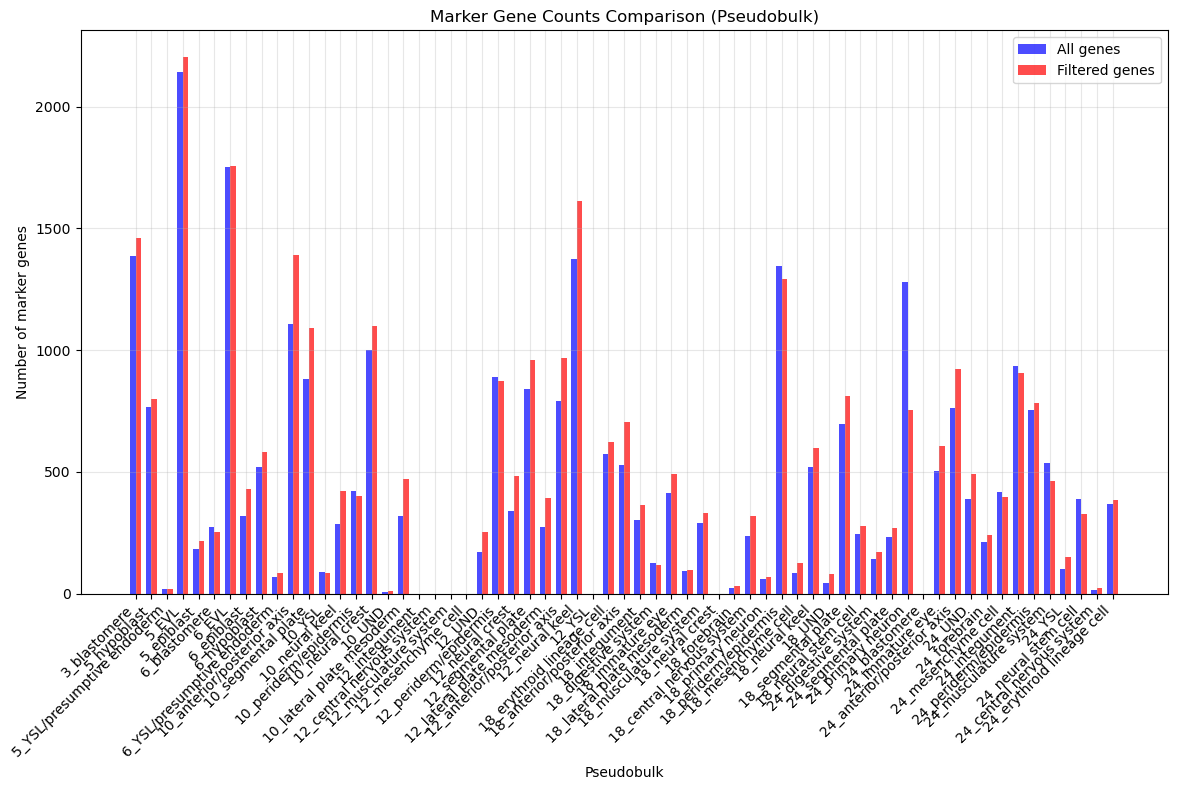

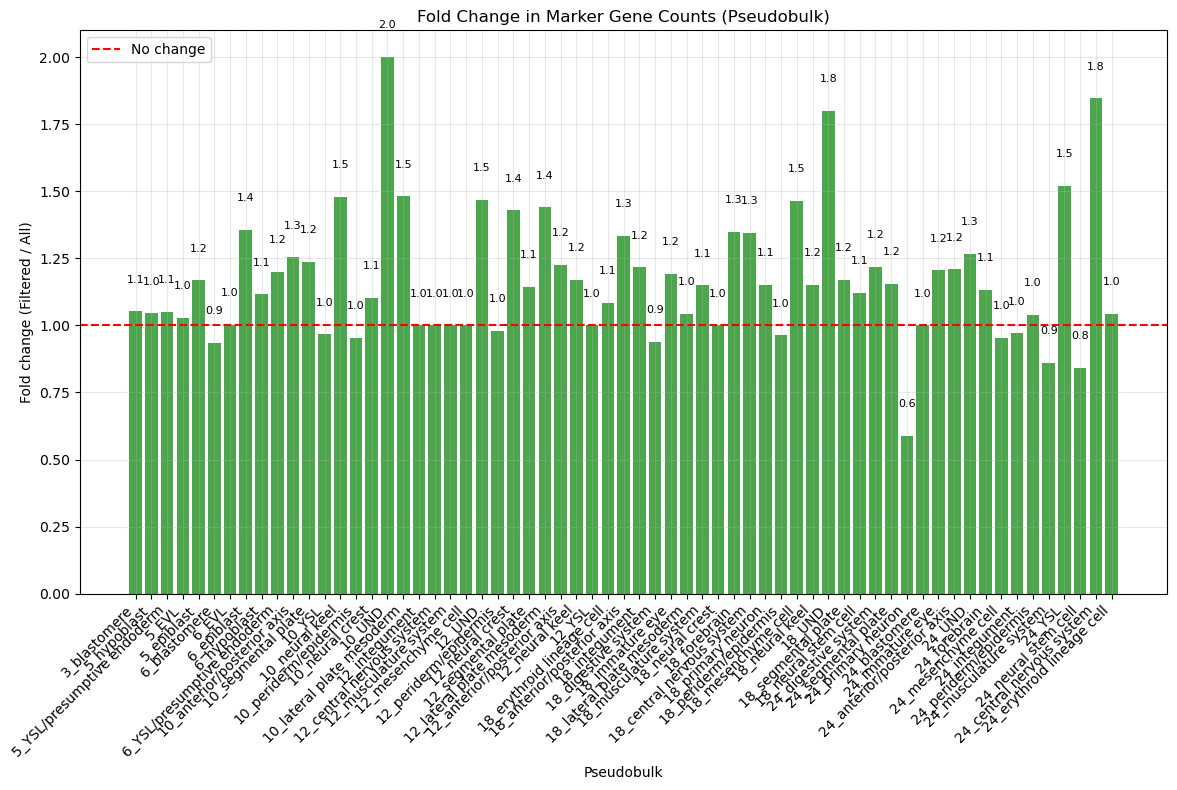

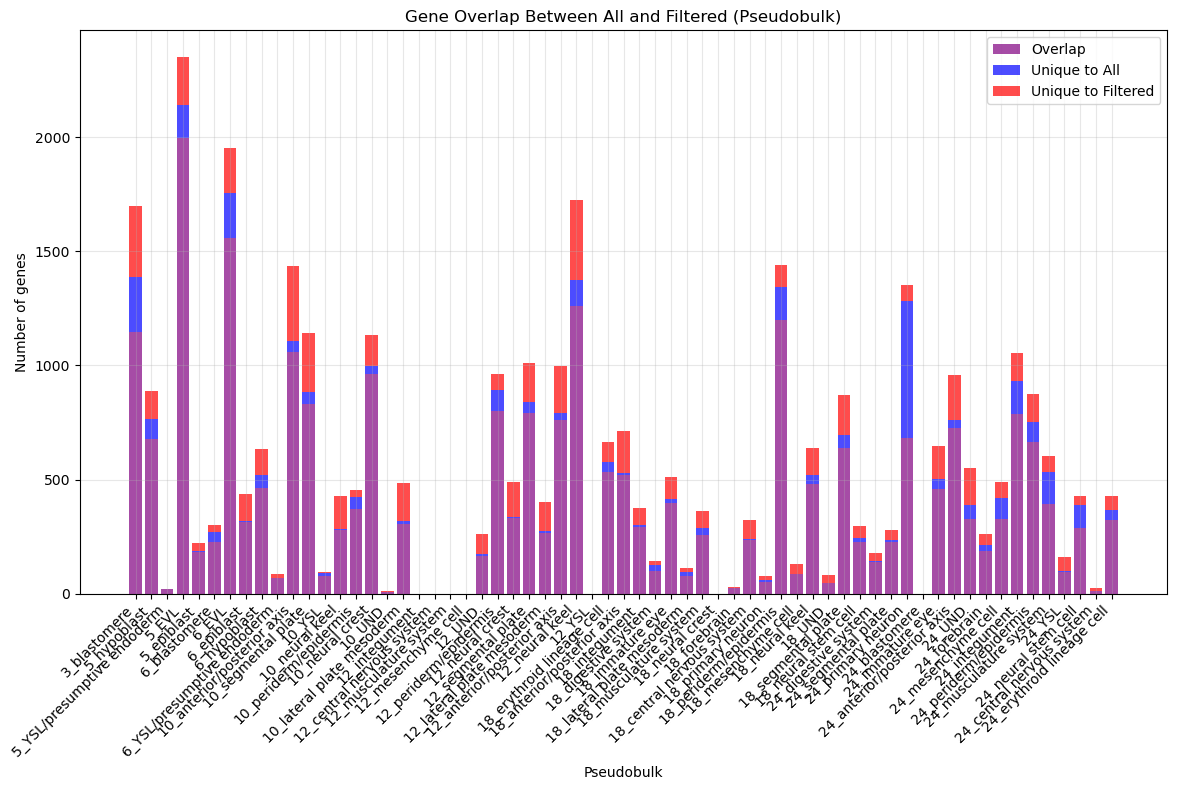

In [43]:

def analyze_marker_gene_differences(marker_genes_all, marker_genes_filtered, analysis_name="Analysis"):
    def extract_stage(group_name):
        try:
            return int(group_name.split('_')[0])
        except:
            return float('inf')  # fallback for unexpected labels

    all_groups = set(marker_genes_all.keys()) | set(marker_genes_filtered.keys())
    sorted_groups = sorted(all_groups, key=extract_stage)

    counts_all = [len(marker_genes_all.get(group, [])) for group in sorted_groups]
    counts_filtered = [len(marker_genes_filtered.get(group, [])) for group in sorted_groups]
    x_pos = np.arange(len(sorted_groups))
    width = 0.35

    # Plot 1: Marker Gene Count Comparison
    plt.figure(figsize=(12, 8))
    plt.bar(x_pos - width/2, counts_all, width, label='All genes', alpha=0.7, color='blue')
    plt.bar(x_pos + width/2, counts_filtered, width, label='Filtered genes', alpha=0.7, color='red')
    plt.xticks(x_pos, sorted_groups, rotation=45, ha='right')
    plt.xlabel('Pseudobulk')
    plt.ylabel('Number of marker genes')
    plt.title(f'Marker Gene Counts Comparison ({analysis_name})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Fold Change
    fold_changes = []
    for group in sorted_groups:
        count_all = len(marker_genes_all.get(group, []))
        count_filtered = len(marker_genes_filtered.get(group, []))
        fc = count_filtered / count_all if count_all > 0 else (float('inf') if count_filtered > 0 else 1)
        fold_changes.append(fc)

    capped_fc = [min(fc, 10) if fc != float('inf') else 10 for fc in fold_changes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(sorted_groups, capped_fc, alpha=0.7, color='green')
    plt.axhline(1, color='red', linestyle='--', label='No change')
    plt.xlabel('Pseudobulk')
    plt.ylabel('Fold change (Filtered / All)')
    plt.title(f'Fold Change in Marker Gene Counts ({analysis_name})')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    for bar, fc in zip(bars, fold_changes):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1, 
                 f'{fc:.1f}' if fc != float('inf') else 'inf', 
                 ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

    # Plot 3: Gene Overlap
    overlaps, unique_all, unique_filtered = [], [], []
    for group in sorted_groups:
        genes_all = set(marker_genes_all.get(group, []))
        genes_filtered = set(marker_genes_filtered.get(group, []))
        overlaps.append(len(genes_all & genes_filtered))
        unique_all.append(len(genes_all - genes_filtered))
        unique_filtered.append(len(genes_filtered - genes_all))

    plt.figure(figsize=(12,8))
    plt.bar(sorted_groups, overlaps, label='Overlap', alpha=0.7, color='purple')
    plt.bar(sorted_groups, unique_all, bottom=overlaps, label='Unique to All', alpha=0.7, color='blue')
    plt.bar(sorted_groups, unique_filtered, 
            bottom=np.array(overlaps) + np.array(unique_all), 
            label='Unique to Filtered', alpha=0.7, color='red')
    plt.xlabel('Pseudobulk')
    plt.ylabel('Number of genes')
    plt.title(f'Gene Overlap Between All and Filtered ({analysis_name})')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        'fold_changes': fold_changes,
        'overlaps': overlaps,
        'unique_all': unique_all,
        'unique_filtered': unique_filtered
    }

results = analyze_marker_gene_differences(
    marker_genes_pseudobulk, 
    marker_genes_pseudobulk_high_exp_genes,
    analysis_name="Pseudobulk"
)


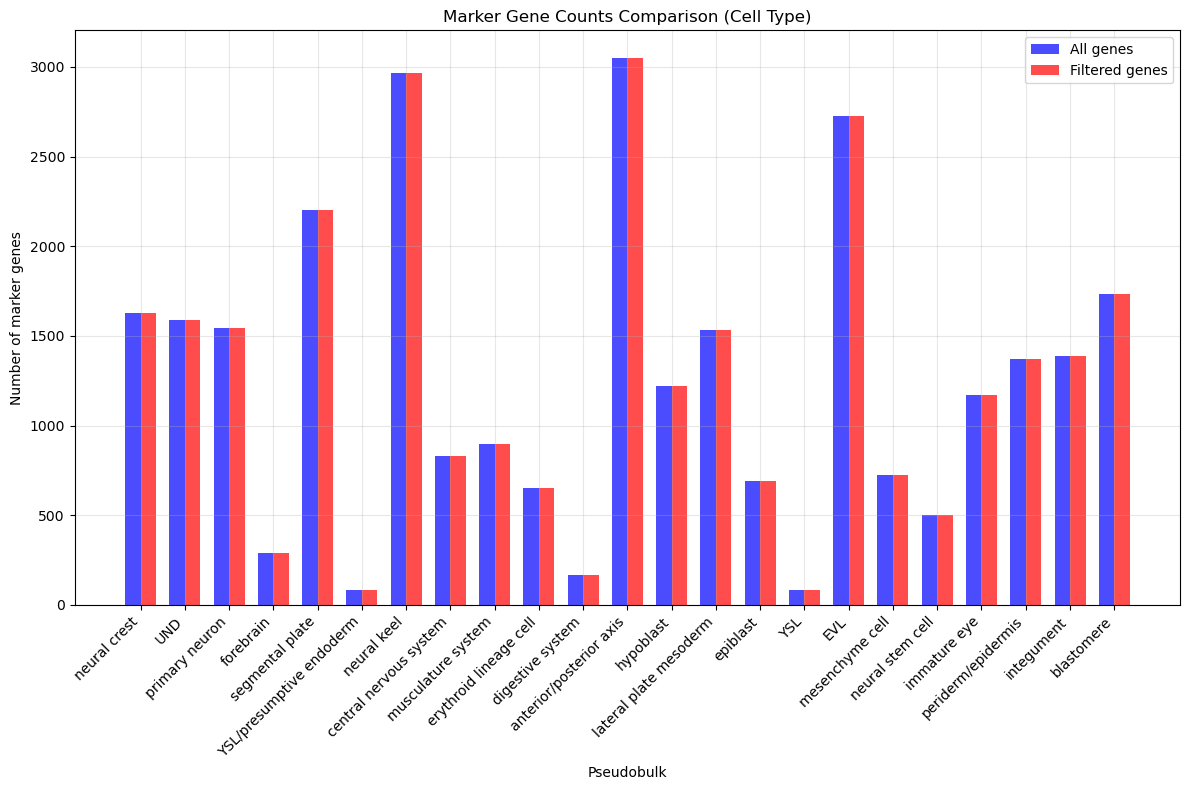

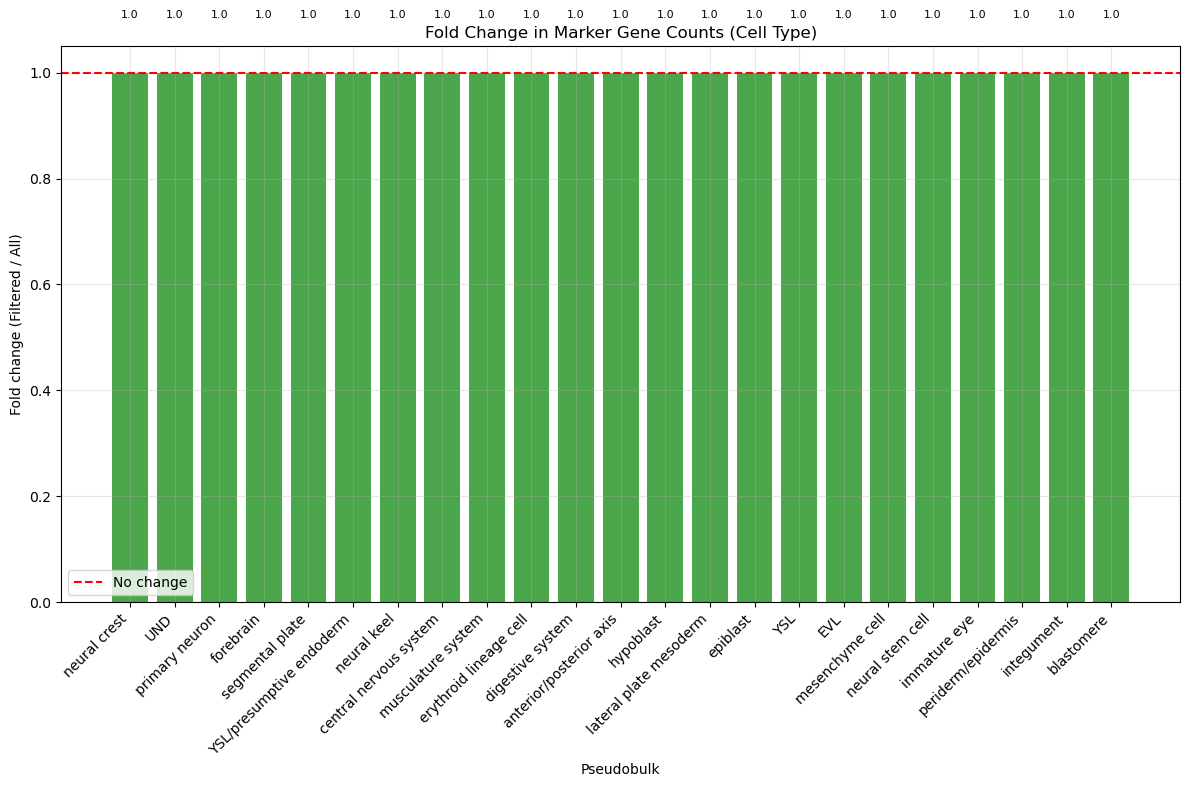

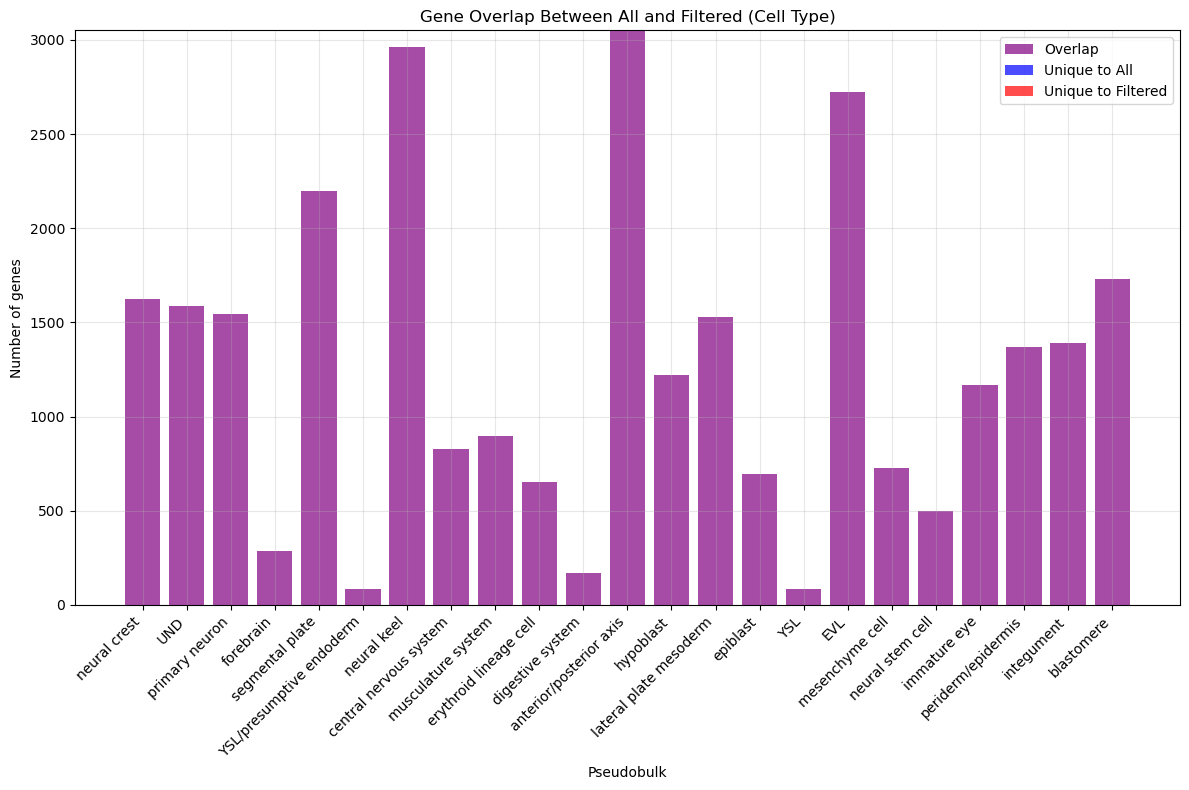

In [44]:
results = analyze_marker_gene_differences(
    marker_genes_celltype, 
    marker_genes_celltype,
    analysis_name="Cell Type"
)

In [45]:
def assign_cells_to_pseudobulk_markers_only(rna_data_unmatched, rna_data_mean_pseudobulk_og, 
                                          marker_genes_dict):
    """
    Assign cells to pseudobulks using only marker genes for each pseudobulk
    """
    cell_names = list(rna_data_unmatched.columns)
    pseudobulk_names = list(rna_data_mean_pseudobulk_og.columns)
    
    # For each cell, compute distance to each pseudobulk using only that pseudobulk's markers
    cell_assignments = {}
    cell_distances = {}
    
    for cell in cell_names:
        min_distance = float('inf')
        best_pseudobulk = None
        distances_to_pseudobulks = {}
        
        for pseudobulk in pseudobulk_names:
            marker_genes = marker_genes_dict[pseudobulk]
            
            if len(marker_genes) == 0:
                # If no markers, use very high distance
                distance = float('inf')
            else:
                # Get expression values for marker genes only
                cell_expression = rna_data_unmatched.loc[marker_genes, cell].values
                pseudobulk_expression = rna_data_mean_pseudobulk_og.loc[marker_genes, pseudobulk].values
                
                # Compute euclidean distance
                distance = np.sqrt(np.sum((cell_expression - pseudobulk_expression)**2))
            
            distances_to_pseudobulks[pseudobulk] = distance
            
            if distance < min_distance:
                min_distance = distance
                best_pseudobulk = pseudobulk
        
        cell_assignments[cell] = best_pseudobulk
        cell_distances[cell] = min_distance
    
    return cell_assignments, cell_distances

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_volcano_plots(mean_df, std_df, sample_sizes, marker_dict, title_prefix="Pseudobulk"):
    genes = mean_df.index
    pseudobulks = mean_df.columns

    for target_pb in pseudobulks:
        other_pbs = [pb for pb in pseudobulks if pb != target_pb]

        mu1 = mean_df[target_pb]
        sd1 = std_df[target_pb]
        n1 = sample_sizes[target_pb]

        mu2 = mean_df[other_pbs].mean(axis=1)
        sd2 = std_df[other_pbs].mean(axis=1)
        n2 = sample_sizes[other_pbs].mean()

        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        from scipy.stats import norm
        from statsmodels.stats.multitest import multipletests

        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

        log_fc = mu1 - mu2

        plt.figure(figsize=(8, 6))
        plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
        
        # Highlight marker genes
        marker_genes = marker_dict[target_pb]
        marker_mask = mean_df.index.isin(marker_genes)
        plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')

        plt.title(f"{title_prefix}: {target_pb}")
        plt.xlabel("Log2 Fold Change")
        plt.ylabel("-log10(FDR-corrected p-value)")
        plt.axhline(-np.log10(0.05), color='grey', linestyle='--', linewidth=1)
        plt.axvline(0.5, color='grey', linestyle='--', linewidth=1)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Call the volcano plot function for pseudobulks
plot_volcano_plots(rna_data_mean_pseudobulk_og, rna_data_std_pseudobulk_og, pseudobulk_counts, marker_genes_per_pseudobulk, title_prefix="Pseudobulk")



NameError: name 'rna_data_mean_pseudobulk_og' is not defined